In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from folium import plugins
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon

In [2]:
n = 10  # every 100th line = 1% of the lines
df18 = pd.read_csv("On-street_Car_Parking_Sensor_Data_-_2019.csv",skiprows=lambda i: i % n != 0 )
# df19 = pd.read_csv("On-street_Car_Parking_Sensor_Data_-_2018.csv",skiprows=lambda i: i % n != 0 )
senSensorData = pd.read_csv("On-street_Parking_Bay_Sensors.csv")  

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Parking in Melbourne

The city of Melbourne is the second largest city in Australia and as many other big cities in the world, the chance of finding a parking spot is small. If you are not that well known in the city it can be hard to know when and where in the city your chances of finding a parking spot will be bigger.

The city of Melbourne is divided into different areas and as you can see by the following chart, there is a big difference in the number of parking spots in the different areas:

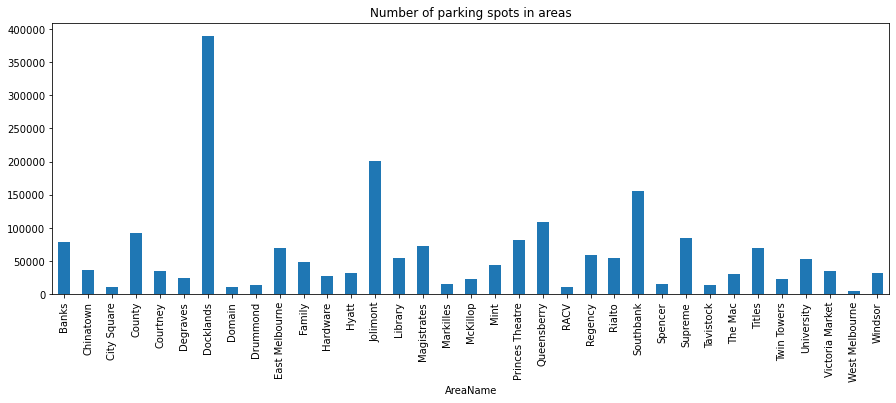

In [4]:
df18 = df18[df18['AreaName']!='All']
parkingsSpots = df18[['AreaName', 'DeviceId']].dropna()
spotsInArea =  parkingsSpots['DeviceId'].groupby(parkingsSpots['AreaName']).size()
figure(figsize=(15,5))
spotsInArea.plot(kind = 'bar', title = "Number of parking spots in areas",sharex='True', fig=figure)
plt.show()

#hourData = data[(data['Category'] == 'LARCENY/THEFT') &
#                (pd.to_datetime((data['Time']), format="%H:%M").dt.hour == 19) &
#                (data['Date'].dt.year == 2014) &
#                (data['Date'].dt.month < 6)].sort_values('Time')
#drugdata = data[(data['Category'] == 'DRUG/NARCOTIC') & (data['Date'].dt.year == 2016) & (data['Date'].dt.month >= 6) & (data['Date'].dt.month <=7)]

By just looking at the number of parking spots in the area, it seems that the chances of finding a parking spot would be bigger in the Docklands area as there are a lot more spots to find than in the other areas.

However, the chance of finding a parking spot will also depend on the time of day. From the following chart you can see that in general the chance of finding an available parking spot is much bigger in the very early or very late hours of the day and very low during the working hours from 7-18.

Around 18 there is a spark in the number of unavailable parking spots. This might be explained by an overlap of the people who live in the city coming home and the people from outside the city still being at work.

At midnight there seem to be a spark in number of unavailable parking spots. This seem to be an error in the dataset. In the discribtion of the data it states that: "There are a number of records where the arrival and departure times have not been recorded. If the time has not been recorded the time is calculated from midnight of the arrival day to either midnight of the departure day or to the departure time.". This is the reason that we see a peak in unavailable parking spots at midnight.

In [5]:
df18['ArrivalTime'] = pd.to_datetime(df18['ArrivalTime'], format="%m/%d/%Y %I:%M:%S %p")
df18['DepartureTime'] = pd.to_datetime(df18['DepartureTime'], format="%m/%d/%Y %I:%M:%S %p")

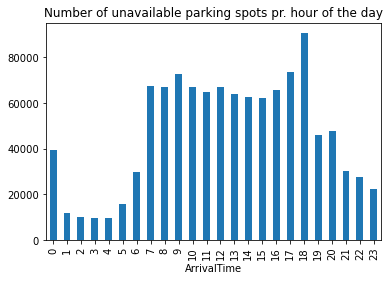

In [43]:
spotTakenDf = df18

crime = spotTakenDf[spotTakenDf['VehiclePresent'] == True].groupby(spotTakenDf['ArrivalTime'].dt.hour).size()
crime.plot(kind = 'bar', title = "Number of unavailable parking spots pr. hour of the day",sharex='True')
plt.show()

From looking at the above charts it might seem that the chances of finding an available parking spot would be highest in the Docklands district in the early or late hours of the day. This can, however, be tricky as Docklands might be far from where you want to go and the hours might not suit the time that you have to go to the city.

To further investigate where the best parking possibilities are in the city, we can take a closer look at the parking spots in the different districts according the the hour of the day.

Here we can see that it is not all areas where it can be difficult to get a parking spot during the working hours of the day. An example of this could be County or Rialto. Here there seems to be a tendency where there are a lot of available spots from 10-15 during the day, so if this is where you are headed or somewhere near there - you have a very good chance of finding a parking spot in those areas during those hours.

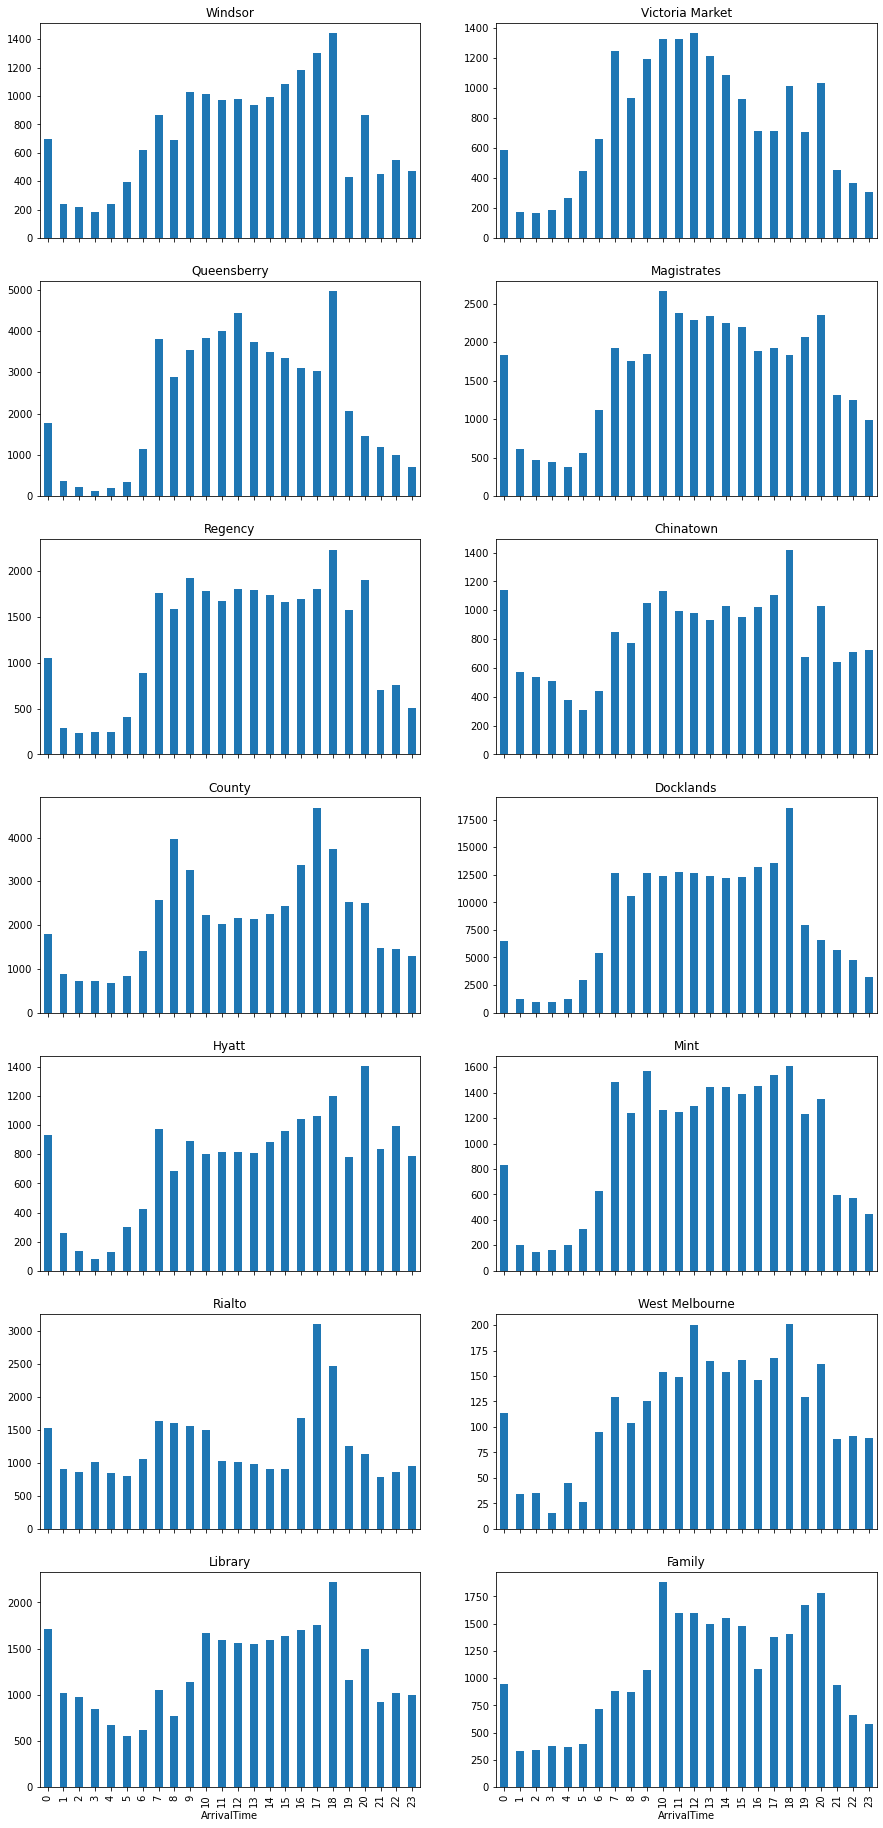

In [7]:
areas = set(['Library', 'Regency', 'Queensberry', 'The Mac', 'Princes Theatre', 'Courtney', 'Drummond', 'Hardware', 'Supreme', 'City Square', 'Domain', 'McKillop', 'Tavistock', 'Degraves', 'Markilles', 'Southbank', 'West Melbourne', 'Victoria Market', 'East Melbourne', 'Spencer', 'Jolimont', 'Docklands', 'Mint', 'Family', 'Twin Towers', 'Hyatt', 'Titles', 'Chinatown', 'County', 'Windsor', 'Magistrates', 'University', 'Rialto', 'Banks'])

a=7
b=2
c=1

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = plt.figure(figsize=(15,5))

for x in areas:
    plt.subplot(a,b,c)
    areasub = spotTakenDf[(spotTakenDf['AreaName'] == x) & (spotTakenDf['VehiclePresent'] == True)].groupby(spotTakenDf['ArrivalTime'].dt.hour).size()
    areasub.plot(kind='bar', title = x, sharex = 'True')
    
    c = c + 1
    if c > 14:
        break
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=5, wspace=0.2, hspace=0.2)
plt.show()

Now we have a pretty good picture of which hours of the day there are most available parking spots in the different areas during the day. This could also vary according to the day of the week.

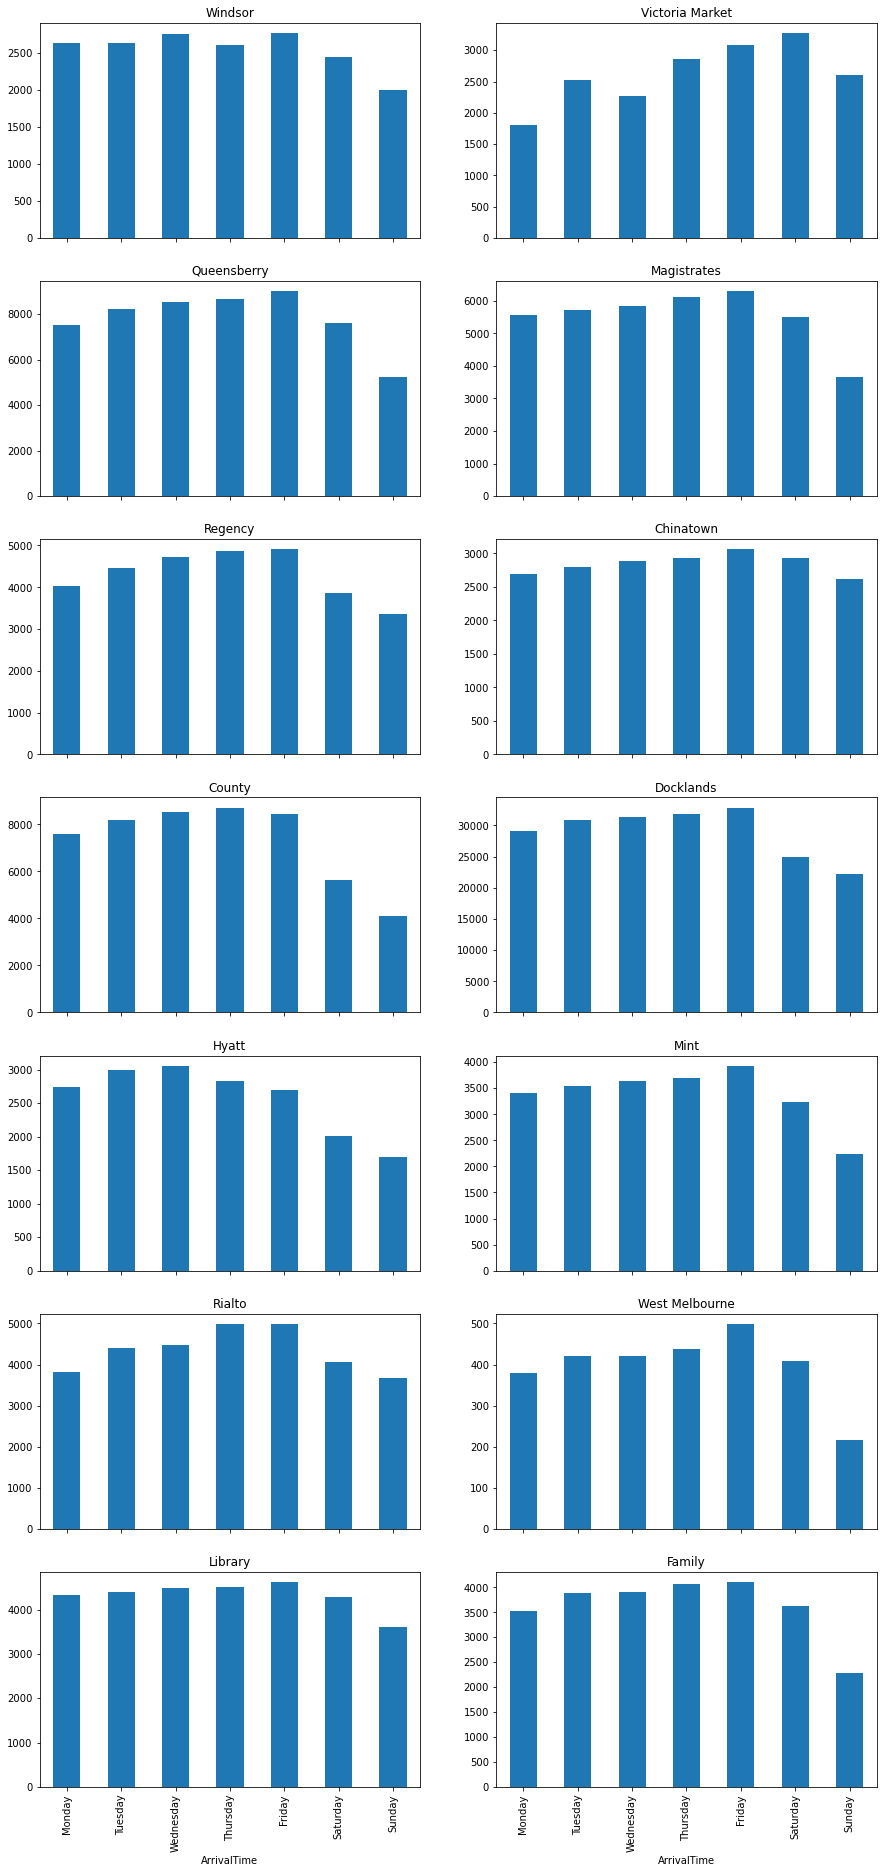

In [8]:
areas = set(['Library', 'Regency', 'Queensberry', 'The Mac', 'Princes Theatre', 'Courtney', 'Drummond', 'Hardware', 'Supreme', 'City Square', 'Domain', 'McKillop', 'Tavistock', 'Degraves', 'Markilles', 'Southbank', 'West Melbourne', 'Victoria Market', 'East Melbourne', 'Spencer', 'Jolimont', 'Docklands', 'Mint', 'Family', 'Twin Towers', 'Hyatt', 'Titles', 'Chinatown', 'County', 'Windsor', 'Magistrates', 'University', 'Rialto', 'Banks'])

a=7
b=2
c=1

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = plt.figure(figsize=(15,5))

for x in areas:
    plt.subplot(a,b,c)
    areasub = spotTakenDf[(spotTakenDf['AreaName'] == x) & (spotTakenDf['VehiclePresent'] == True)].groupby(spotTakenDf['ArrivalTime'].dt.day_name()).size().reindex(weekdays)
    areasub.plot(kind='bar', title = x, sharex = 'True')
    
    c = c + 1
    if c > 14:
        break
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=5, wspace=0.2, hspace=0.2)
plt.show()

As you can see from the chart above the general picture here is that more people park in the city from monday through friday as this is the working days. However, there is one area that doesn't follow this general trend. The Victora Market area seems to follow a different pattern where there are more available parking spots during the work days and less during the weekend. To understand why this is we will need to take a closer look at this area:

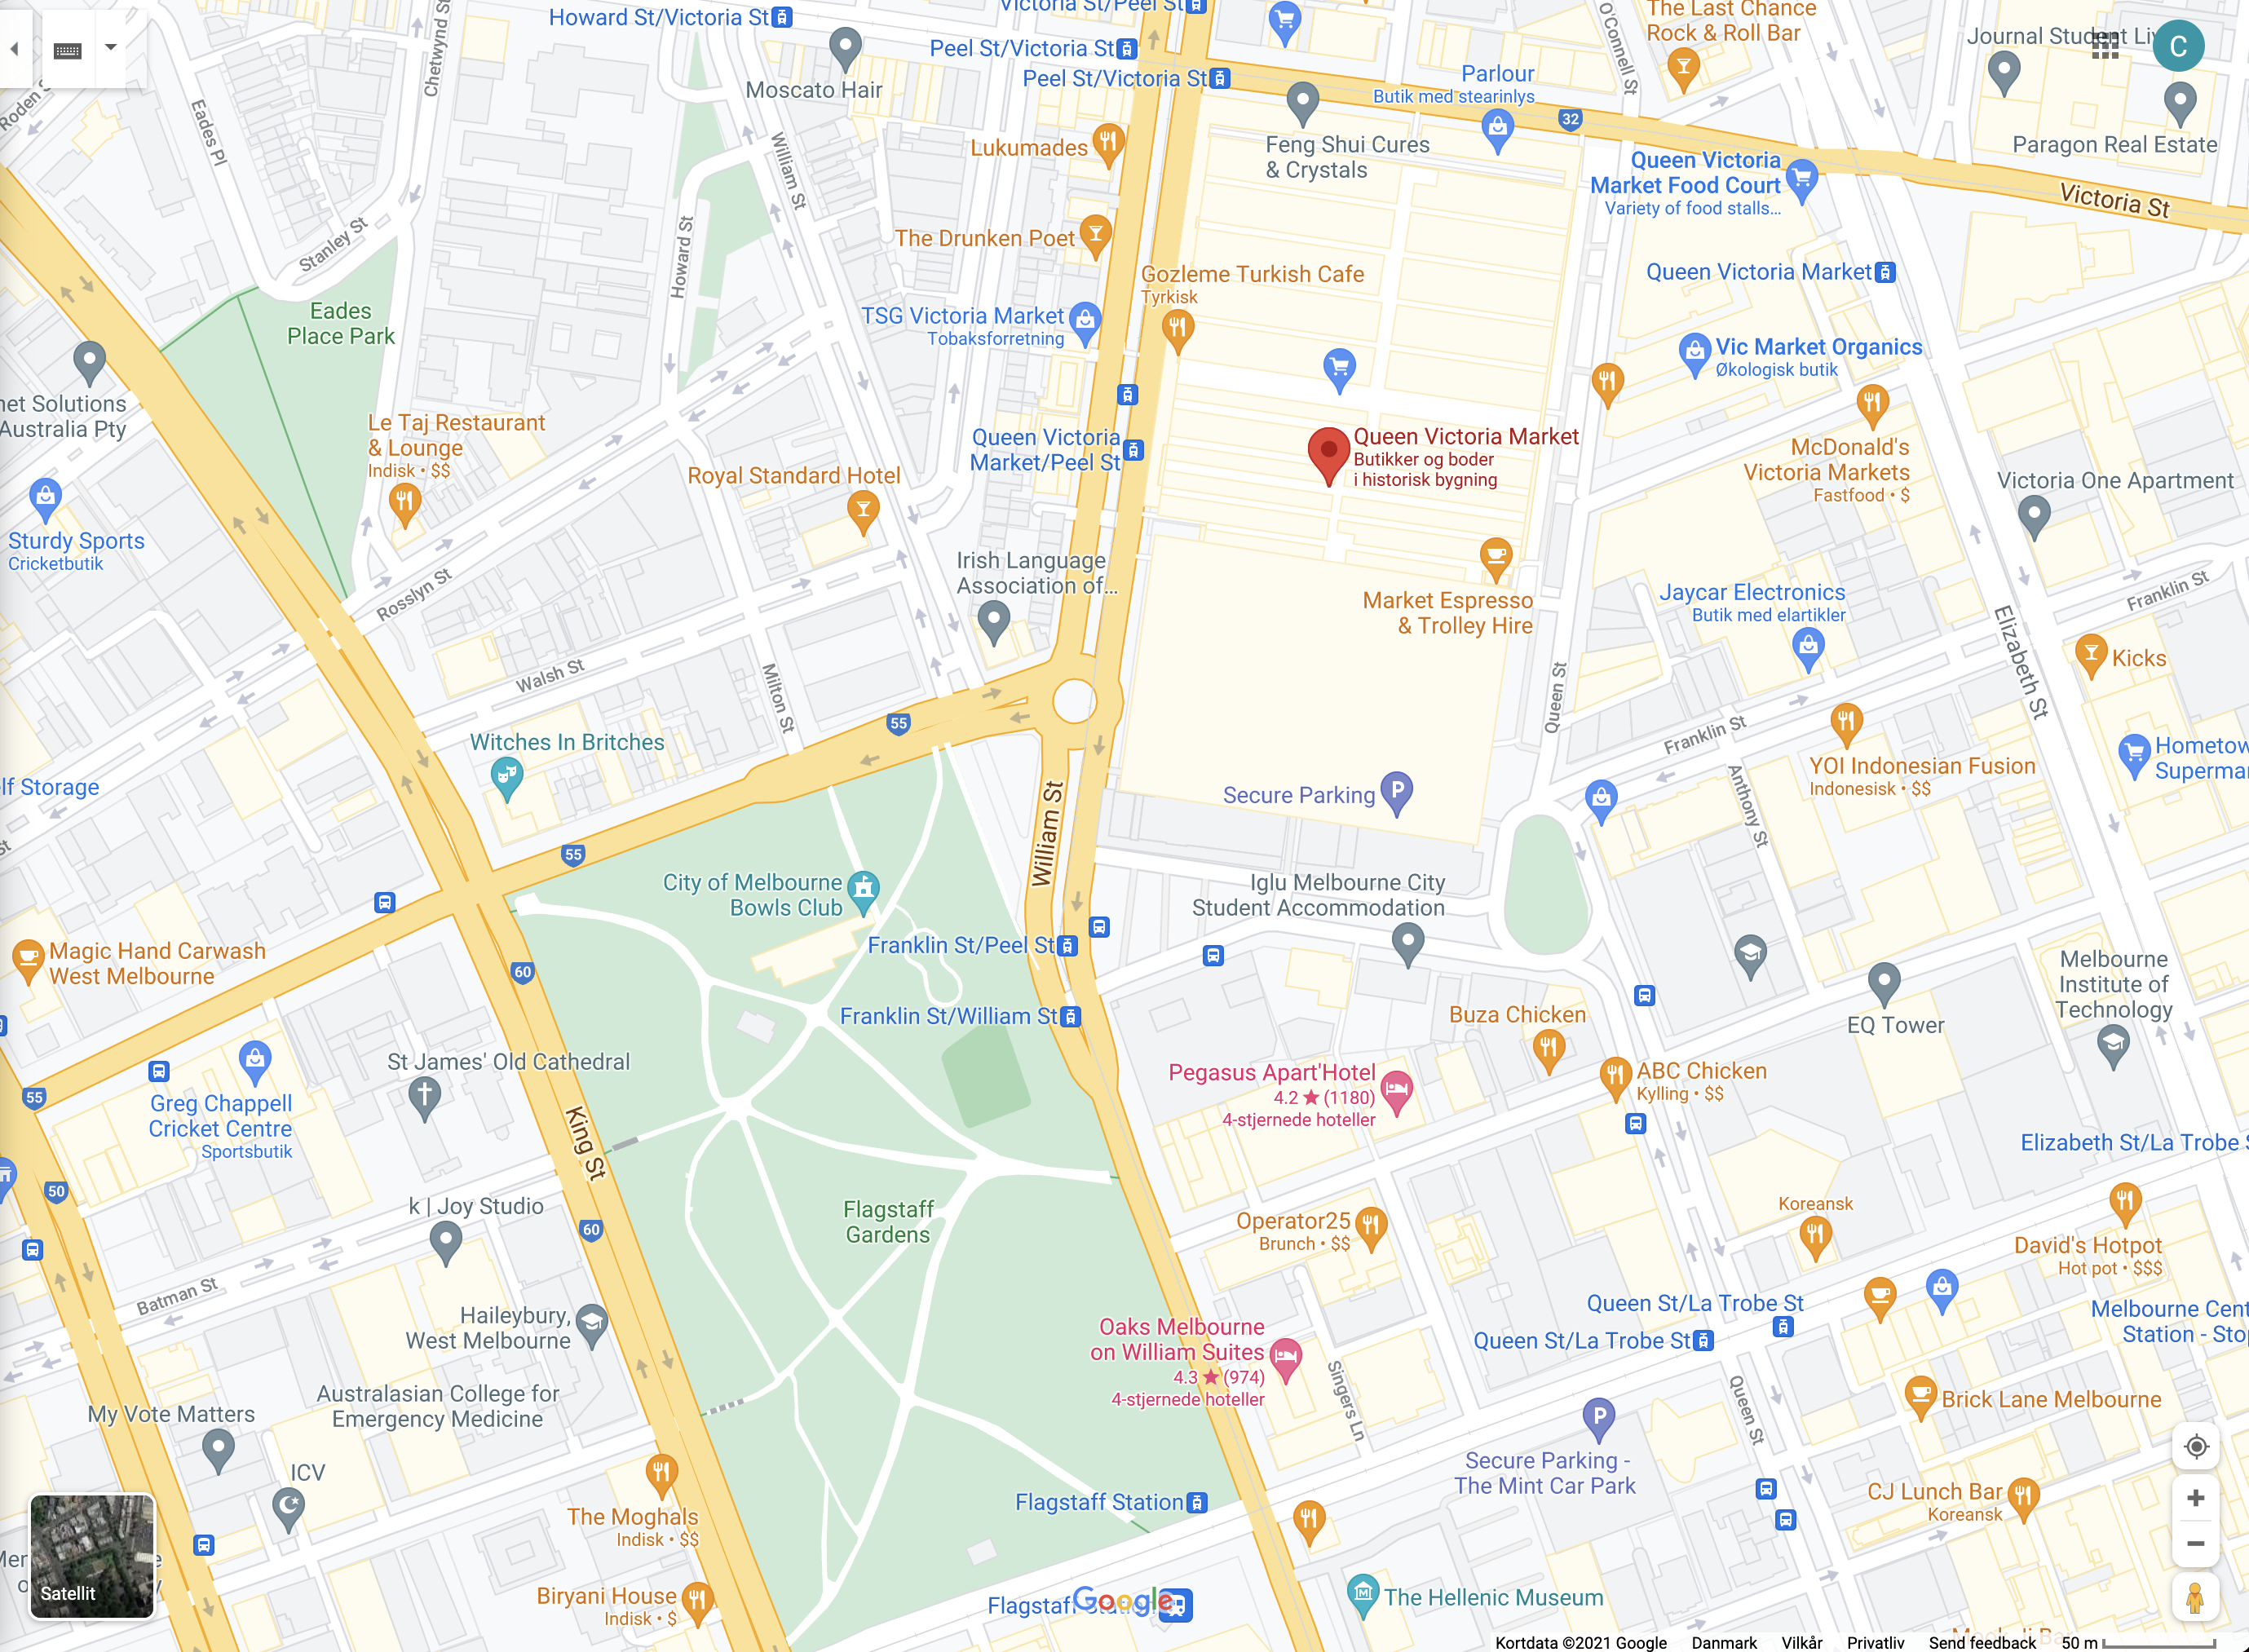

As you can see from the map above the Victoria Market area is an area filled with stores and is placed right next to a big park. When looking at this it makes sense that the Victoria Market is more occupied in the weekends as people might be going there to shop or might be visiting the park nearby during their time off.

Another interesting trend that could be interesting to investigate would be to see if the number of available parking spots are also dependent on the month of the year. From the chart below you can see that there seem to be a trend that there are a lot more available parking spots during the early months of the year e.g. January and Feburary and there seem to be a lot less available parking spots the further we get in the year. At first - coming from the northern hemosphere - it might seem a bit strange. But in Autralia the summer and winter months are opposite of ours. In the summer months there are probably a lot more people who choose to take the bike or use public transportation than during the winter. Another factor is that the summer vacation in Australia begins in late December and lasts until approximately late January.

Taking into account what we have just been looking at it might seem strange that there are not a lot of available parking spots during December as this is also a summer month. This might be because of christmas as there are a lot of people christmas shopping during this month and then take their car into the city.

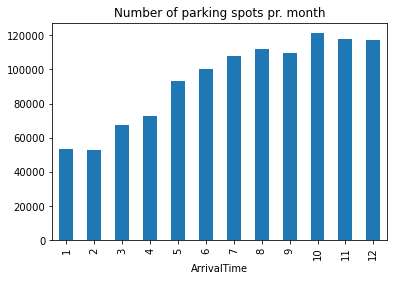

In [9]:
spotTakenDf = df18

crime = spotTakenDf[spotTakenDf['VehiclePresent'] == True].groupby(spotTakenDf['ArrivalTime'].dt.month).size()
crime.plot(kind = 'bar', title = "Number of parking spots pr. month",sharex='True')
plt.show()

In [10]:
spotTakenDf['count'] = 0
spotTakenDf['ArrivalHour'] = spotTakenDf['ArrivalTime'].dt.hour
spotsInArea =  spotTakenDf[spotTakenDf['VehiclePresent'] == False].groupby(['AreaName', 'ArrivalHour'])['count'].size()
spotsInArea = spotsInArea.reset_index()
spotTakenDf['total'] = 0
spotsInAreaTotal =  spotTakenDf[spotTakenDf['VehiclePresent'] == False].groupby(['AreaName'])['total'].size()
spotsInAreaTotal = spotsInAreaTotal.reset_index()
merged = pd.merge(spotsInAreaTotal, spotsInArea, on='AreaName')
merged['mean'] = merged['total'] / merged['count']
merged = merged[merged['AreaName'] != 'All']
merged['mean'] = merged['mean'].apply(np.ceil)
merged['mean'] = merged['mean'].astype(int)

In [11]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
from bokeh.models import ColumnDataSource, FactorRange, Legend

Loading BokehJS ...

To give a little overview of how the number of occupied parking spots are changing during the day we have created a heatmap over time to give a better understanding of this.

In [16]:
geoFile = open("On-street Parking Bays.geojson")
geoData = json.load(geoFile)
dfGeo = pd.json_normalize(geoData['features'])
dfGeo = dfGeo.dropna()
senSensorData.rename(columns = {"st_marker_id": "StreetMarker"}, 
          inplace = True)

In [17]:
resultdf = pd.merge(df18, senSensorData, on='StreetMarker')

In [18]:
resultdfsample = resultdf.sample(10000)
heatsus = [[[row['lat'],row['lon']] for index, row in resultdfsample[resultdfsample['ArrivalTime'].dt.hour == i].iterrows()] for i in range(1,24)]

In [19]:
SFmap = folium.Map([-37.810935, 144.946457], zoom_start=13)
hm = plugins.HeatMapWithTime(heatsus,auto_play=True, max_opacity = 0.8)
hm.add_to(SFmap)
SFmap

You might have gotten a good idea of the parking possibilities in the city from our overview but if you need to get an idea of where you yourself should park if you are going to be driving into the city og Melbourne, then you can use the below interactive charts where you can investigate when you will have a better chance of getting a parking spot in the area that you need to go to.

In [ ]:
output_notebook()

In [ ]:
areas = set(['Library', 'Regency', 'Queensberry', 'The Mac', 'Princes Theatre', 'Courtney', 'Drummond', 'Hardware', 'Supreme', 'City Square', 'Domain', 'McKillop', 'Tavistock', 'Degraves', 'Markilles', 'Southbank', 'West Melbourne', 'Victoria Market', 'East Melbourne', 'Spencer', 'Jolimont', 'Docklands', 'Mint', 'Family', 'Twin Towers', 'Hyatt', 'Titles', 'Chinatown', 'County', 'Windsor', 'Magistrates', 'University', 'Rialto', 'Banks'])

dailyHours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
df18['Hours'] = df18['ArrivalTime'].dt.hour
normalizedData = pd.DataFrame(dailyHours, columns = ['Hours'])
sample10 = df18.sample(100000)
sample1=sample10['DeviceId'].groupby(sample10['AreaName']).size()
sample1=sample1.reset_index()
sample=pd.merge(sample1, sample10, on='AreaName')
#sample['idCounts'] = np.where(sample['AreaName'] == c, True, False)
for c in areas:
    sample[sample['AreaName'] == c]
for x in areas:
    dailyHoursArray = []
    for i in range(0,24):
        dailyHoursArray.append(sample[(sample['AreaName'] == x) & (sample['ArrivalTime'].dt.hour == i) & (sample['VehiclePresent'] == True)].size/sample.loc[sample['AreaName']==x, 'DeviceId_x'].values[0])
    normalizedData[x] = dailyHoursArray

On the below chart you can see the number of occupied parking spots in the selected area during the hours of the day.

In [ ]:
sourceData = ColumnDataSource(normalizedData)

In [ ]:
hoursStrings=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
p = figure(x_range = FactorRange(factors=hoursStrings), x_axis_label = "hour of the day", width = 1500, height = 850, margin = 10)

In [ ]:
colorCodes= ['#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff', '#005eff', '#7300ff', '#d000ff', '#ff00f7', '#ff006f', '#828282', '#000000', '#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff', '#005eff', '#7300ff', '#d000ff', '#ff00f7', '#ff006f', '#828282', '#000000', '#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff']
barColumn = {}
items = []

for index, i in enumerate(areas):
    barColumn[i] = p.vbar(x="Hours", top = i, source = sourceData, muted_alpha= 0.05, muted=True, fill_color=colorCodes[index], width=(0.90))
    items.append((i,[barColumn[i]]))

In [20]:
legend = Legend(items = items, location=(0,-30))
p.add_layout(legend, 'left')
p.legend.click_policy="mute"
show(p)

On the following chart you can investigate the number of occupied parking spots during the days of the week according to the selected area.

In [31]:
areas = set(['Library', 'Regency', 'Queensberry', 'The Mac', 'Princes Theatre', 'Courtney', 'Drummond', 'Hardware', 'Supreme', 'City Square', 'Domain', 'McKillop', 'Tavistock', 'Degraves', 'Markilles', 'Southbank', 'West Melbourne', 'Victoria Market', 'East Melbourne', 'Spencer', 'Jolimont', 'Docklands', 'Mint', 'Family', 'Twin Towers', 'Hyatt', 'Titles', 'Chinatown', 'County', 'Windsor', 'Magistrates', 'University', 'Rialto', 'Banks'])

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df18['Hours'] = df18['ArrivalTime'].dt.hour
normalizedData = pd.DataFrame(weekdays, columns = ['Weekdays'])
sample10 = df18.sample(100000)
sample1=sample10['DeviceId'].groupby(sample10['AreaName']).size()
sample1=sample1.reset_index()
sample=pd.merge(sample1, sample10, on='AreaName')
#sample['idCounts'] = np.where(sample['AreaName'] == c, True, False)
for c in areas:
    sample[sample['AreaName'] == c]
for x in areas:
    dailyHoursArray = []
    for i in range(0,7):
        dailyHoursArray.append(sample[(sample['AreaName'] == x) & (sample['ArrivalTime'].dt.day_name() == weekdays[i]) & (sample['VehiclePresent'] == True)].size/sample.loc[sample['AreaName']==x, 'DeviceId_x'].values[0])
    normalizedData[x] = dailyHoursArray

In [32]:
sourceData = ColumnDataSource(normalizedData)

In [36]:
weekdaysStrings=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pp = figure(x_range = FactorRange(factors=weekdaysStrings), x_axis_label = "weekdays", width = 1000, height = 850, margin = 10)

In [37]:
colorCodes= ['#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff', '#005eff', '#7300ff', '#d000ff', '#ff00f7', '#ff006f', '#828282', '#000000', '#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff', '#005eff', '#7300ff', '#d000ff', '#ff00f7', '#ff006f', '#828282', '#000000', '#ff0000', '#ff5e00', '#ffd900', '#c8ff00', '#3cff00', '#00ffb7', '#00eaff']
barColumn = {}
items = []

for index, i in enumerate(areas):
    barColumn[i] = pp.vbar(x="Weekdays", top = i, source = sourceData, muted_alpha= 0.05, muted=True, fill_color=colorCodes[index], width=(0.90))
    items.append((i,[barColumn[i]]))

In [38]:
legend = Legend(items = items, location=(0,-30))
pp.add_layout(legend, 'left')
pp.legend.click_policy="mute"
show(pp)